In [1]:
from pycocotools.coco import COCO
from PIL import Image
from torchvision import transforms
from utils import clean_sentences
from model import EncoderCNN, DecoderRNN
import torch
import os
from data_loader import get_loader
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('./cocoapi/PythonAPI')
%matplotlib inline

transform_test = transforms.Compose([transforms.Resize(256),                          # smaller edge of image resized to 256
                                     transforms.CenterCrop(224),                      # get 224x224 crop from random location
                                     transforms.ToTensor(),                           # convert the PIL Image to a tensor
                                     transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                                                          (0.229, 0.224, 0.225))])

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test',
                         batch_size=1)


c:\Users\user\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


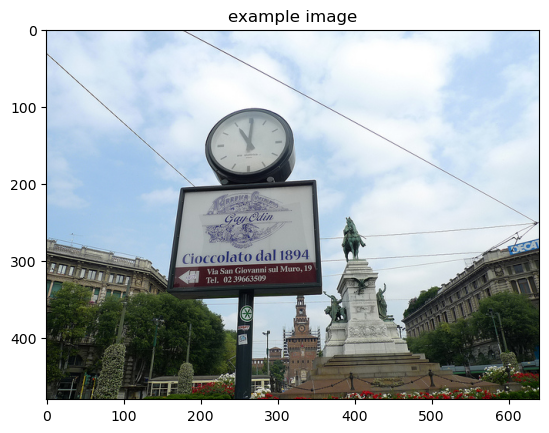

In [2]:
# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
encoder_file = "encoder.pt"
decoder_file = "decoder.pt"

embed_size = 300
hidden_size = 256

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)     # type: ignore
# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)


DecoderRNN(
  (word_embeddings): Embedding(8852, 300)
  (lstm): LSTM(300, 256, batch_first=True)
  (hidden2target): Linear(in_features=256, out_features=8852, bias=True)
)

In [5]:
def get_caption(img_path=None):
    if img_path is not None:
        orig_image = Image.open(img_path).convert("RGB")
        image = transform_test(orig_image).unsqueeze(0)
    else:
        orig_image, image = next(iter(data_loader))
        orig_image = np.squeeze(orig_image)
    
    plt.imshow(orig_image)
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.generate_captions(features)    
    sentence = ' '.join(clean_sentences(data_loader.dataset.vocab.idx2word, output)) + '.'      # type: ignore
    print(sentence)


Run the code cell below (multiple times, if you like!) to test how this function works.

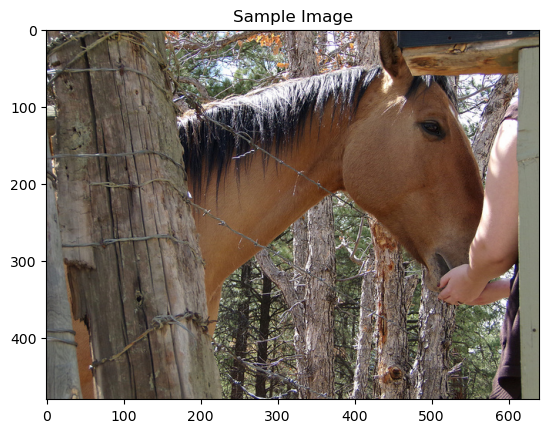

gallon depicting enclose recycling gooey polish net positioned crusts three gyro fast descends gooey gleaming forehead tofu snowboarder necktie.


In [8]:
get_caption()
